# SXSW Conference Sentiment Analysis

**By [Czarina Luna](http://czarinaluna.com/)**

### Contents
* [I. Overview](#I.-Overview)
* [II. Business Problem](#II.-Business-Problem)
* [III. Data Understanding](#III.-Data-Understanding)
    * [3.1 Natural Language Processing](#3.1-Natural-Language-Processing)
    * [3.2 Text Data Visualization](#3.2-Text-Data-Visualization)
    * [3.3 Word Embeddings](#3.3-Word-Embeddings)
* [IV. Data Modeling](#IV.-Data-Modeling)
    * [4.1 Classification Algorithms](#4.1-Classification-Algorithms)
    * [4.2 Hyperparameter Tuning](#4.2-Hyperparameter-Tuning)
    * [4.3 Clustering Analysis](#4.3-Clustering-Analysis)
* [V. Results and Recommendations](#V.-Results-and-Recommendations)
* [VI. Further Research](#VI.-Further-Research)

## I. Overview

An analysis and natural language processing of thousands of tweets is completed to predict sentiments during SXSW and provide insights to brands and products at the conference. Though the extra trees classifier has the highest test accuracy, the Multinomial Naive Bayes model performs the best at classifying negative and positive sentiments. Clustering analysis is performed to identify themes and topics that emerged, and recommendations are made accordingly.

## II. Business Problem

South by Southwest (SXSW) is an annual conference where creative industries converge to showcase innovations in technology and the creative arts. The company that organizes the conference may be able to enhance customer experience by detecting and understanding sentiments of the attendees from past conference. Doing so will allow them to gain an understanding of the public opinion about events and brands featured at the conference. Using Twitter data I describe patterns and topics that emerge about the conference and Apple and Google products in particular at the SXSW 2011.

## III. Data Understanding

The Twitter dataset ([data file](https://github.com/czarinagluna/sxsw-sentiment-analysis/tree/main/data)) is composed of over 9,000 tweets about SXSW 2011 labeled as `negative`, `positive`, or `no emotion`. The tweets are the independent feature used to predict the multiclass sentiments. One other feature on the dataset is `emotion_in_tweet_is_directed_at`, which identifies Apple and Google products mentioned in the tweets. However almost 6,000 of the tweets are missing the product values, and so the feature will not be used later.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/data.csv', encoding='latin1')

# Quick look at the data structure
df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


In [2]:
# Rename columns for convenience
df.columns = ['text', 'product', 'target']

Missing values:

In [3]:
df.isna().sum()

text          1
product    5802
target        0
dtype: int64

In [4]:
# Remove one missing value for the independent feature and any duplicates
df = df.dropna(subset=['text']).drop_duplicates(subset=['text'])

In [5]:
df['product'].value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: product, dtype: float64

Imbalanced dataset:

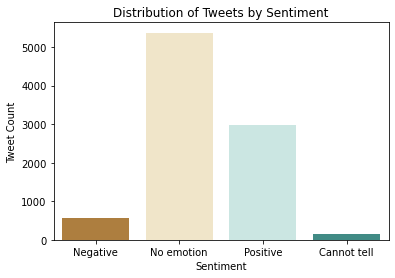

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

classes = ['Negative emotion', 'No emotion toward brand or product', 'Positive emotion', "I can't tell"]
sns.countplot(x='target', data=df, palette='BrBG', order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Positive', 'Cannot tell'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('data/images/fig0.png', dpi=200, transparent=True)
plt.show()

In [7]:
# Drop values for "cannot tell"
df = df.drop((df.loc[df['target']=="I can't tell"]).index)

In [8]:
# Group products by Apple and Google brands
apple = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
google = ['Google', 'Other Google product or service', 'Android App', 'Android']

df['brand'] = df['product'].apply(lambda x: 'google' if x in google else ('apple' if x in apple else 'unknown'))

In [9]:
pd.DataFrame(df.groupby(['brand', 'target'])['text'].count())

text
brand   target                                  
apple   Negative emotion                     387
        No emotion toward brand or product    65
        Positive emotion                    1943
google  Negative emotion                     131
        No emotion toward brand or product    26
        Positive emotion                     719
unknown Negative emotion                      51
        No emotion toward brand or product  5281
        Positive emotion                     306

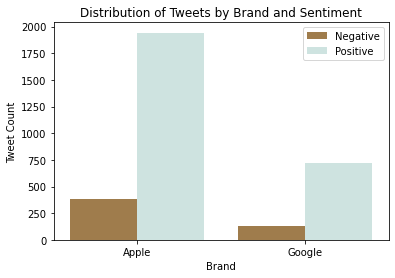

In [10]:
brands = df.loc[(df['brand']!='unknown') & (df['target']!='No emotion toward brand or product')]

fig, ax = plt.subplots()
sns.countplot(x='brand', data=brands, hue='target', palette=['#AD7E3E', '#CBE6E2'])

ax.set(title='Distribution of Tweets by Brand and Sentiment', 
       xticklabels=['Apple', 'Google'], 
       xlabel='Brand', ylabel='Tweet Count')
ax.legend(['Negative', 'Positive'])

plt.show()

Not including the neutral sentiments which actually count the least in the tweets identified with either of the brands, both Apple and Google received more positive sentiments than negative, overall. And more tweets are tagged as Apple product or service than Google.

In [11]:
# Replace sentiments with numerical values
emotions = {'No emotion toward brand or product':1, 'Positive emotion':2, 'Negative emotion':0}
df['target'] = df['target'].map(emotions)

Feature engineering:

In [12]:
# Create features for length of tweet by word count and by character
df['length'] = df['text'].apply(lambda x: len(x.split()))
df['characters'] = df['text'].apply(lambda x: len(x))

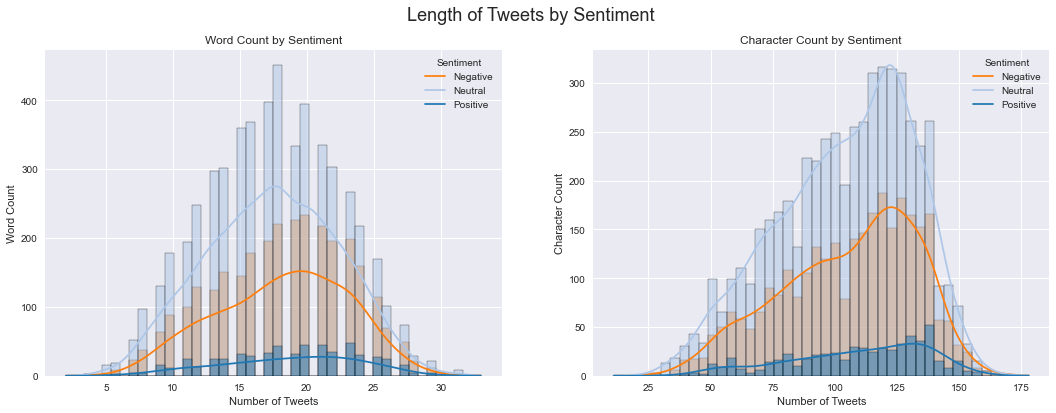

In [13]:
plt.style.use('seaborn')

fig, axes = plt.subplots(ncols=2, figsize=(18,6))
fig.suptitle('Length of Tweets by Sentiment', fontsize=18)

# Plot distribution of word count by sentiment
sns.histplot(x='length', data=df, bins='auto', kde=True, hue='target', legend=True, ax=axes[0], palette='tab20')
axes[0].set_title('Word Count by Sentiment')
axes[0].set_xlabel('Number of Tweets')
axes[0].set_ylabel('Word Count')
axes[0].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

# Plot distribution of Character count by sentiment
sns.histplot(x='characters', data=df, bins='auto', kde=True, hue='target', legend=True, ax=axes[1], palette='tab20')
axes[1].set_title('Character Count by Sentiment')
axes[1].set_xlabel('Number of Tweets')
axes[1].set_ylabel('Character Count')
axes[1].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

plt.savefig('data/images/fig1.png', dpi=200, transparent=True)
plt.show()

- The graph on the left shows the length of tweet by count of `words`, which appears to be about normally distributed. 
- The graph on the right shows the length of tweet by count of `characters`, which distribution appears to be slightly skewed to the left.

Overall, the graphs show **no significant difference** in the length of tweets among negative, neutral, and positive sentiments.

***

**Train Test Split**

To further explore the data below while avoiding data leakage, let's now split the data into train and test sets—and to hold out the latter for final evaluation in data modeling later.

In [14]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

### 3.1 Natural Language Processing

Natural Language Processing is used for text mining. In order to perform an analysis of text data, data preprocessing is first done to transform text into a data format that can be used in machine learning.

Let's take a sample of tweets to work with for now:

In [15]:
samples = pd.DataFrame(X_train.sample(5, random_state=112221))
samples['label'] = [y_train[idx] for idx in samples.index]
samples

,text,label
5758,RT @mention Funny that even CNN is saying to s...,1
7358,Vinh: Flipboard is a step forward for iPad mag...,2
6306,RT @mention Mayer: 20% of Google searches are ...,1
4092,&quot;Apple is the most elegant fascist compan...,0
2369,It's official! I'm buying an iPad. #SXSW #elevate,2


**3.1.1 Basic Cleaning and Tokenization**

In [16]:
sample = samples.loc[6306, 'text']
sample

'RT @mention Mayer: 20% of Google searches are for local information #SXSW ^pr'

*Step 1:* Standardization by lowercasing everything.

In [17]:
sample = sample.lower()
sample

'rt @mention mayer: 20% of google searches are for local information #sxsw ^pr'

*Step 2:* Remove special characters such as punctuation.

In [18]:
import re
sample = re.sub(r'([^A-Za-z0-9|\s|[:punct:]]*)', '', sample)
sample

'rt mention mayer: 20 of google searches are for local information sxsw pr'

In [19]:
sample = sample.replace('[^a-zA-Z#]', ' ').replace('quot', '')
sample = ' '.join([i for i in sample.split() if len(i)>3])
sample

'mention mayer: google searches local information sxsw'

*Step 3:* Tokenization by splitting the string—transforming it into a list of words.

In [20]:
sample = sample.split()
sample

['mention', 'mayer:', 'google', 'searches', 'local', 'information', 'sxsw']

**3.1.2 Lemmatization and Stopwords**

To apply the following techniques, I utilize one of the most popular frameworks for NLP that is the Python library, Natural Language Toolkit `NLTK`.
***

*Step 4:* Remove stopwords and other words—to reduce the dimensionality of the data down to only the words that contain important information.

In [21]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')

# Remove words related to the conference that appear across all sentiments
# and terms specific to the twitter platform
sxsw = ['sxsw', 'sxswi', 'link', 'quot', 'rt', 'amp', 'mention', 'apple', 'google', 'iphone', 'ipad', 
        'ipad2', 'austin', 'today', 'quotroutearoundquot', 'rtmention', 'store', 'doesnt', 'theyll']
stopwords.extend(sxsw)

In [22]:
sample = [word for word in sample if word not in stopwords]
sample

['mayer:', 'searches', 'local', 'information']

*Step 5:* Lemmatization—to reduce each word to its most basic form, such as `searches` to `search`:

In [23]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

sample = [lemmatizer.lemmatize(word) for word in sample]
sample

['mayer:', 'search', 'local', 'information']

In [24]:
# Put all the words back together
sample = ' '.join(sample)
sample

'mayer: search local information'

In [25]:
# Create a function that compiles all the steps taken above
def preprocess(text):
    '''
    Processes text data by basic cleaning, tokenization, lemmatization, and stopwords removal.
    '''
    text = text.apply(lambda x: x.lower())
    text = text.apply(lambda x: re.sub(r'([^A-Za-z0-9|\s|[:punct:]]*)', '', x))
    text = text.apply(lambda x: x.replace('[^a-zA-Z#]', ' ').replace('quot', '').replace(':', '').replace('sxsw', ''))
    text = text.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3]))
    text = text.apply(lambda x: x.split())
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    text = text.apply(lambda x: [word for word in x if word not in stopwords])
    text = text.apply(lambda x: ' '.join(x))
    return text

In [26]:
# Apply the function to the sample tweets
samples['text'] = preprocess(samples['text'])
samples

,text,label
5758,funny even saying stay clear friday launch,1
7358,vinh flipboard step forward mag right path wir...,2
6306,mayer search local information,1
4092,elegant fascist company america flipboard,0
2369,official buying elevate,2


In [27]:
# Apply the function to the train and test sets
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)

**3.1.3 Vectorization**

Once the text data is cleaned, the last step is to convert it to vectors. A basic way to vectorize text data is using the `CountVectorizer` which counts the number of times each word appears.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

words = cv.fit_transform(X_train_processed)
sumwords = words.sum(axis=0)

frequencies = [(word.title(), sumwords[0,i]) for word, i in cv.vocabulary_.items()]
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)

dffrequencies = pd.DataFrame(frequencies, columns=['word', 'frequency'])

Let's plot the distribution of the highest frequencies:

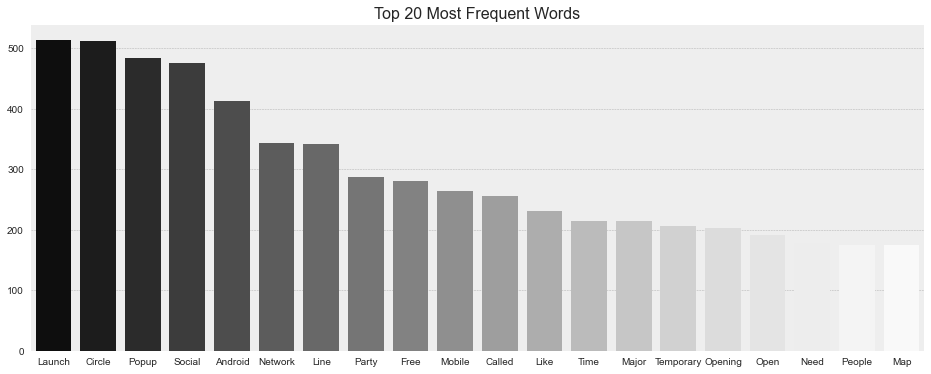

In [29]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(16,6))

sns.barplot(x='word', y='frequency', data=dffrequencies.head(20), palette='Greys_r')
ax.set_title('Top 20 Most Frequent Words', fontsize=16)
ax.set(xlabel=None, ylabel=None)

plt.show()

### 3.2 Text Data Visualization

To highlight significant textual data points, I use the data visualization technique that is widely used for analysis of social media texts that is the `WordCloud`, which represents text data and indicates frequencies by the size of the words.

In [30]:
# Visualize text data only from the train set 
train_set = pd.concat([X_train_processed, y_train], axis=1)

In [31]:
from nltk.tokenize import RegexpTokenizer
regex_token = RegexpTokenizer(r'\w+')

# Create corpus of all the words by sentiment
sentiments = {}
for idx, name in enumerate(['negative_target', 'neutral_target', 'positive_target']):
    text = train_set['text'].loc[train_set['target']==idx].tolist()
    text = ' '.join(text)
    sentiments[name] = set(regex_token.tokenize(text))

In [32]:
negative = ' '.join(sentiments['negative_target'])
neutral = ' '.join(sentiments['neutral_target'])
positive = ' '.join(sentiments['positive_target'])

# unique_negative = ' '.join(A-(B|C))
# unique_neutral = ' '.join(B-(A|C))
# unique_positive = ' '.join(C-(A|B))

In [33]:
from PIL import Image
from wordcloud import WordCloud

# Create a function that generates a word cloud
def wordcloud(sentiment, shape, filename, color, random_state=1):
    '''
    Generates masked wordcloud and saves image to file.
    '''
    mask = np.array(Image.open(f'data/images/mask/{shape}.jpeg'))
    
    cloud = WordCloud(max_font_size=175, width=1000, height=1000, mask=mask, max_words=125, 
                      colormap=color, background_color='rgba(255,255,255,0)', mode='RGBA', 
                      random_state=random_state).generate(sentiment)
    plt.axis('off')
    plt.imshow(cloud, interpolation='bilinear')
    plt.savefig(f'data/images/{filename}.png', dpi=200, transparent=True)

**Positive Sentiments**

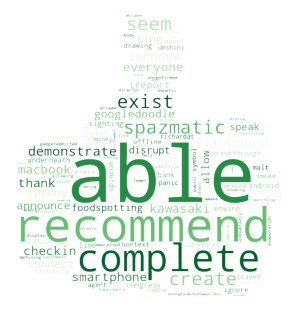

In [34]:
wordcloud(positive, 'positive', 'fig2', 'Greens_r')

*Guy Kawasaki* is one of the speakers at SXSW 2011. 

Some tweets mentioning `kawasaki`:

In [35]:
def tweets(keyword, n=5):
    '''
    Returns tweets containing keyword.
    '''
    head = df.loc[df['text'].str.contains(keyword, case=False), ['text']].head(n)
    return head
    
tweets('kawasaki')

,text
60,&quot;via @mention : {link} Guy Kawasaki talks...
109,Kawasaki: &quot;Not C.S. Lewis level reasoning...
110,Kawasaki: &quot;pagemaker saved Apple.&quot; O...
111,Kawasaki: &quot;pagemaker saved Apple.&quot; O...
496,At a DSLR film discussion moderated by Guy Kaw...


In [36]:
df.loc[60, 'text']

"&quot;via @mention : {link} Guy Kawasaki talks 'Enchanted' at SXSW - HE knows his stuff! #books #internet #Apple #sxsw  &quot;"

In [37]:
df.loc[496, 'text']

'At a DSLR film discussion moderated by Guy Kawasaki, of Apple fame. Packed house! #SXSW'

**Negative Sentiments**

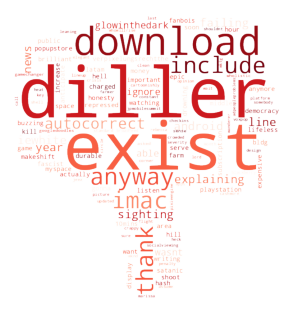

In [38]:
wordcloud(negative, 'negative', 'fig3', 'Reds_r')

In [39]:
tweets('imac')

,text
835,"God, it's like being at #sxsw - have iMac, Mac..."
4398,Sound of My Voice was shot exploiting Apple &a...
4399,Sound of My Voice was shot exploiting Apple &a...
4412,Arrived in Austin for #SXSW. Our hotel room is...
4919,Andrew K of PRX equates the homogeneity of the...


A sample tweet mentioning `imac`:

In [40]:
df.loc[835, 'text']

"God, it's like being at #sxsw - have iMac, MacBook, iPhone and BlackBerry all staring at me. Enough! Time to read a book - remember those?"

In [41]:
# Create corpus of all the words by brand
tech = {}

for brand in ['apple', 'google']:
    text = train_set['text'].loc[df.loc[X_train_processed.index,'brand']==brand].tolist()
    text = ' '.join(text)
    tech[brand] = set(regex_token.tokenize(text))
    
applecloud = ' '.join(tech['apple'])
googlecloud = ' '.join(tech['google'])

**Apple**

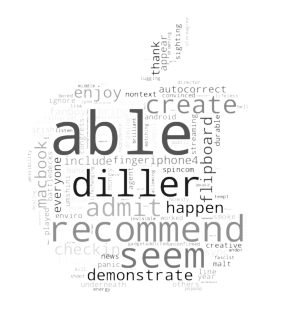

In [42]:
wordcloud(applecloud, 'apple', 'fig4', 'Greys_r')

**Google**

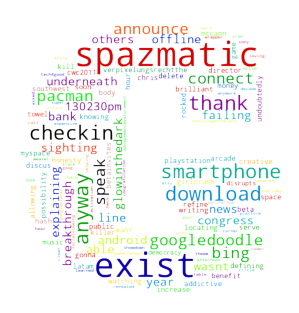

In [43]:
wordcloud(googlecloud, 'google', 'fig5', 'nipy_spectral_r', random_state=2)

Let's generate wordclouds by brand *and* sentiment.

In [44]:
# Remove more SXSW-related words
sxswords = ['sxsw', 'link', 'apple', 'people', 'one', 'year', 'ipad', 'google', 'store', 'quot', 'iphone', 'austin', 'app', 'ipad2', 'android', 'pop', 'amp', 'new', 'line', 'day', 'time', 'today', 'launch', 'major', 'title', 'via', 'network', 'called', 'u', 'v', 'say', 'see']

def remove(text):
    '''
    Removes SXSW-related words from text.
    '''
    text = text.split()
    text = [word for word in text if word not in sxswords]
    string = ' '.join(text)
    return string

def groupby(brand, target, sentiment):
    '''
    Groups data by brand and sentiment.
    '''
    brand = train_set.loc[df.loc[X_train_processed.index,'brand']==brand]
    data = brand.loc[brand['target']==target]
    text = ''
    
    for row in data['text']:
        text += row

    group = remove(text)
    group = ''.join(group)
    
    return group

**Positive Sentiments toward Apple**

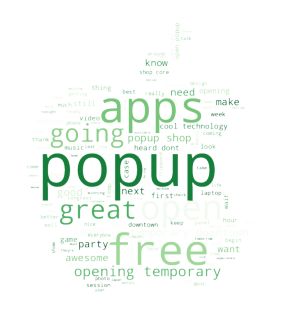

In [45]:
positive_apple = groupby('apple', 2, 'positive')

wordcloud(positive_apple, 'apple', 'fig6', 'Greens')

Apple *opened a temporary pop-up store* during SXSW 2011.

Some tweets mentioning `popup`:

In [46]:
tweets('popup', n=10)

,text
82,Nice! RT @mention Apple opening popup store f...
183,It's like 10pm at night and there is a line ar...
266,Say what? Apple #sxsw popup store in Austin! {...
280,"The #sxsw Apple Popup Store is open at noon, h..."
329,Nerd bait at #SXSW! Apple set to open popup sh...
360,This will be out of control: #Apple set to ope...
614,I've been having meetings while I'm in line at...
615,#Apple to Hawk iPad 2 at #SXSW Festival Popup ...
628,"Apple and HP popups at #SXSW. Gee, I wonder wh..."
928,ÛÏ@mention Not a rumor: Apple doing popup sto...


In [47]:
df.loc[280, 'text']

"The #sxsw Apple Popup Store is open at noon, has a fresh shipment of iPad 2's, and I'm pretty sure I'm going to get one. [fingers crossed]"

In [48]:
df.loc[614, 'text']

"I've been having meetings while I'm in line at the #SXSW PopUp Apple Store for the iPad2. I love this place!"

**Negative Sentiments toward Apple**

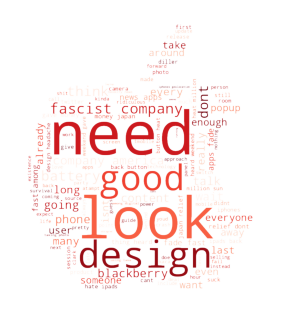

In [49]:
negative_apple = groupby('apple', 0, 'negative')

wordcloud(negative_apple, 'apple', 'fig7', 'Reds_r')

*Apple is a fascist company* was quoted by Kara Swisher during an [interview](https://www.theguardian.com/technology/pda/2011/mar/13/flipboard-sxsw-2011) at SXSW 2011, which was caught by many and retweeted over Twitter. 

Some tweets mentioning `fascist company`:

In [50]:
tweets('fascist company')

,text
1355,@mention - #Apple is the classiest fascist com...
2272,Too quotable --&gt; RT ÛÏ@mention &quot;Apple...
3468,Kara Swisher: Apple is the most stylish fascis...
4092,&quot;Apple is the most elegant fascist compan...
5075,RT @mention ÛÏThe classiest fascist company i...


In [51]:
df.loc[2272, 'text']

'Too quotable --&gt; RT \x89ÛÏ@mention &quot;Apple is the most elegant fascist company in America.&quot; #flip-board #SXSW'

In [52]:
df.loc[3468, 'text']

'Kara Swisher: Apple is the most stylish fascist company in America #sxsw'

**Positive Sentiments toward Google**

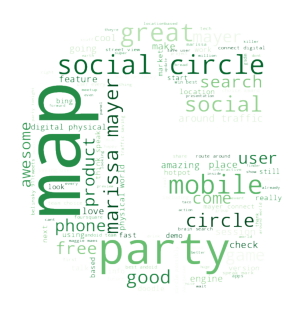

In [53]:
positive_google = groupby('google', 2, 'positive')

wordcloud(positive_google, 'google', 'fig8', 'Greens_r')

*Marissa Meyer* known as Google's first female engineer was a keynote at SXSW 2011.

Some tweets mentioning `marissa mayer`:

In [54]:
tweets('marissa mayer')

,text
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...
181,#sxsw day 1 - Marissa Mayer: Google Will Conne...
225,"google is about search, but local' marissa may..."
355,Racing to ballroom D to see @mention Marissa M...
365,The quiet before the storm at #SXSW - Looking ...


In [55]:
df.loc[4, 'text']

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [56]:
df.loc[355, 'text']

'Racing to ballroom D to see @mention Marissa Mayer. #sxsw #sxswi'

In [57]:
df.loc[365, 'text']

"The quiet before the storm at #SXSW - Looking forward to seeing Google's Marissa Mayer"

**Negative Sentiments toward Google**

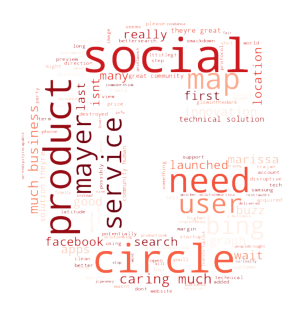

In [58]:
negative_google = groupby('google', 0, 'negative')

wordcloud(negative_google, 'google', 'fig9', 'Reds_r')

The words *caring much* were spoken by Tim O'Reilly, founder and CEO of O'Reilly Media, in one of the opening sessions at SXSW 2011. The [full quote](https://www.forbes.com/sites/davidewalt/2011/03/11/tim-oreilly-speaks-at-sxsw/?sh=16c5913721ec) was:
> "I think that Google lost its way by trying to care too much for its business as opposed to caring about their users and their value to the world. And Larry [Page] has that."

Some tweets mentioning `caring`:

In [59]:
tweets('caring')

,text
1453,So true!!! RT @mention 'Google lost its way by...
2328,Clear +succinct visions make for great UX (thi...
2972,#sxsw: @mention Thinks Larry's elevation at Go...
3340,I think #Google lost their way by caring too m...
4223,@mention lost its way by caring too much about...


In [60]:
df.loc[1453, 'text']

"So true!!! RT @mention 'Google lost its way by caring too much for the business vs. the users' - @mention #psych #sxsw"

In [61]:
df.loc[3340, 'text']

"I think #Google lost their way by caring too much about their business (instead of their users) Tim O'Reilly #sxsw #pnid"

### 3.3 Word Embeddings

To create word embeddings, the `Word2Vec` model is used. The model computes word vectors using a neural network that results to an embedding space where semantic relationships between the word vectors are captured.

In [62]:
import warnings
warnings.filterwarnings('ignore')

# Import Word2Vec from the Gensim library
from gensim.models import Word2Vec
from nltk import word_tokenize

wordtovec = X_train_processed.map(word_tokenize)

# Instantiate Word2Vec model
model = Word2Vec(wordtovec, window=5, min_count=1, workers=4)
model.train(wordtovec, total_examples=model.corpus_count, epochs=model.epochs)

wv = model.wv

In [63]:
# Create a function to show the most similar words to a given word
def show_most_similar(word, length=10):
    '''
    Returns word vectors with highest similarity.
    '''
    return wv.most_similar(word, topn=length)

In [64]:
show_most_similar('apple')

[('smart', 0.9971441030502319),
 ('pic', 0.9969177842140198),
 ('line', 0.9958877563476562),
 ('outside', 0.995820164680481),
 ('retail', 0.995522677898407),
 ('block', 0.9953539371490479),
 ('forming', 0.9952980279922485),
 ('setting', 0.9952477216720581),
 ('already', 0.9946107864379883),
 ('ipads', 0.9943540692329407)]

In [65]:
show_most_similar('google')

[('barton', 0.9861379861831665),
 ('paid', 0.9860417246818542),
 ('forget', 0.9856571555137634),
 ('know', 0.9855206608772278),
 ('digi', 0.9853360056877136),
 ('figure', 0.985310435295105),
 ('come', 0.9852781295776367),
 ('guard', 0.9852519035339355),
 ('bring', 0.9852421283721924),
 ('exclusive', 0.9851640462875366)]

In [66]:
show_most_similar('iphone')

[('jones', 0.9656640887260437),
 ('gowalla', 0.9651976227760315),
 ('told', 0.964905858039856),
 ('insane', 0.964823842048645),
 ('change', 0.9647723436355591),
 ('employee', 0.9647445678710938),
 ('031211', 0.9647277593612671),
 ('appears', 0.9647048115730286),
 ('graph', 0.9646733403205872),
 ('bought', 0.964590311050415)]

In [67]:
show_most_similar('android')

[('check', 0.9988545775413513),
 ('team', 0.9987890124320984),
 ('version', 0.9987574815750122),
 ('interface', 0.9986114501953125),
 ('award', 0.9985647201538086),
 ('band', 0.9985442161560059),
 ('great', 0.9984450340270996),
 ('designing', 0.9984422326087952),
 ('headache', 0.998393177986145),
 ('available', 0.9982353448867798)]

The most common pairs of consecutive words, also known as bi-grams:

In [68]:
from nltk.collocations import *
from nltk import TweetTokenizer

tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

tweets = tweet_tokenizer.tokenize(' '.join(wordtovec.apply(lambda x: ' '.join(x))))

In [69]:
# Use BigramAssocMeasures from nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(tweets)
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

In [70]:
# Display the top 20 bigrams
bigrams[:20]

[(('social', 'network'), 0.007517455218720025),
 (('called', 'circle'), 0.005242142363202391),
 (('network', 'called'), 0.005219835374422807),
 (('major', 'social'), 0.004639853666153606),
 (('launch', 'major'), 0.004506011733476098),
 (('circle', 'possibly'), 0.0037252671261906356),
 (('marissa', 'mayer'), 0.003011443485243927),
 (('opening', 'temporary'), 0.002186084900399295),
 (('popup', 'shop'), 0.0020745499565013718),
 (('open', 'popup'), 0.0018514800687055254),
 (('temporary', 'downtown'), 0.0018291730799259408),
 (('downtown', 'launch'), 0.0015837962033505098),
 (('opening', 'popup'), 0.001316112337995494),
 (('launch', 'social'), 0.0012938053492159093),
 (('rumor', 'opening'), 0.00124919137165674),
 (('includes', 'uberguide'), 0.0010930424501996475),
 (('ubersocial', 'includes'), 0.0010930424501996475),
 (('network', 'circle'), 0.0008699725624038012),
 (('anyone', 'know'), 0.0007584376185058779),
 (('[', 'codes'), 0.0007361306297262932)]

## IV. Data Modeling

**Baseline Model**

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

baseline_model = LogisticRegression(max_iter=1000, random_state=112221)

# Build a pipeline using the Count Vectorizer and Logistic Regression
baseline = Pipeline(steps=[('vectorizer', cv), ('baseline', baseline_model)])
baseline.fit(X_train_processed, y_train)

baseline_pred = baseline.predict(X_test_processed)

accuracy_score(y_test, baseline_pred)

0.6768402154398564

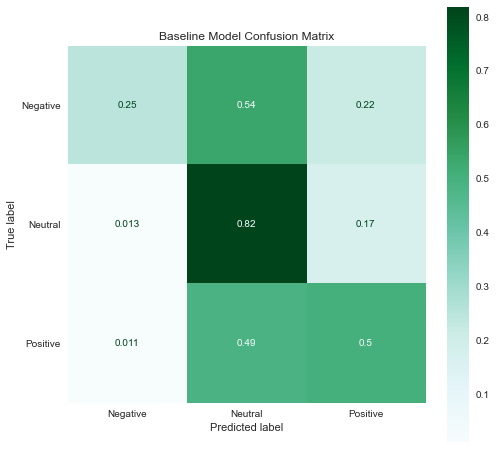

In [72]:
from sklearn.metrics import plot_confusion_matrix

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8,8))

# Plot the confusion matrix of the baseline model
plot_confusion_matrix(baseline, X_test_processed, y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='BuGn')
plt.title('Baseline Model Confusion Matrix')
plt.grid(False)

plt.savefig('data/images/fig10.png', dpi=200, transparent=True)
plt.show()

**Term Frequency-Inverse Document Frequency** measures _the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs_ ([Aditya Sharma](https://www.datacamp.com/community/tutorials/recommender-systems-python%5D)).

Change count vectorizer to the `Tfidf` vectorizer:

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, ngram_range=(1,2))

# Build a pipeline using the TF-IDF Vectorizer and Logistic Regression
tfidfpipe = Pipeline(steps=[('tfidf', tfidf), ('baseline', baseline_model)])
tfidfpipe.fit(X_train_processed, y_train)

tfidf_pred = tfidfpipe.predict(X_test_processed)
accuracy_score(y_test, tfidf_pred)

0.6885098743267505

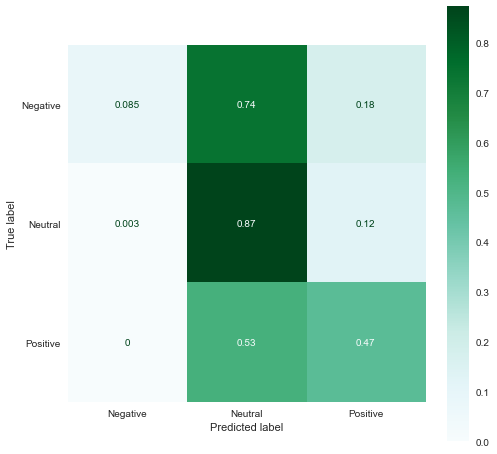

In [74]:
fig, ax = plt.subplots(figsize=(8,8))

plot_confusion_matrix(tfidfpipe, X_test_processed, y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='BuGn')
plt.grid(False)

plt.savefig('data/images/fig11.png', dpi=200, transparent=True)
plt.show()

**Random Oversampling**

To balance the class distribution, random oversampling is done by randomly duplicating examples of the minority classes in the training set.

In [75]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority', random_state=112221)

processed = pd.DataFrame(X_train_processed, columns=['text'])
X_train_res, y_train_res = oversample.fit_resample(processed, y_train)

In [76]:
# Store for retrieval at grid search notebook
%store X_train_res

Stored 'X_train_res' (DataFrame)


In [77]:
# Store for retrieval at grid search notebook
%store y_train_res

Stored 'y_train_res' (Series)


In [78]:
X_train_res = X_train_res.squeeze()

tfidfpipe.fit(X_train_res, y_train_res)

resampled = tfidfpipe.predict(X_test_processed)
accuracy_score(y_test, resampled)

0.6651705565529623

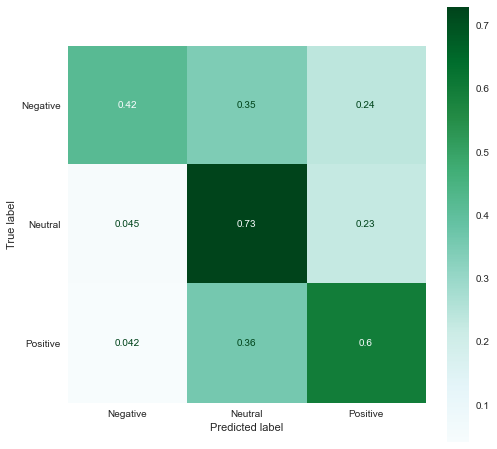

In [79]:
fig, ax = plt.subplots(figsize=(8,8))

# Plot the confusion matrix of the model using the resampled data
plot_confusion_matrix(tfidfpipe, X_test_processed, y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='BuGn')
plt.grid(False)

plt.savefig('data/images/fig12.png', dpi=200, transparent=True)
plt.show()

### 4.1 Classification Algorithms

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Create a function to run the classification models
def run_model(models, model_type, cmap):
    '''
    Fits the model on train set, and returns the confusion matrix and accuracy scores.
    '''
    metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Accuracy', 'Type'])
    
    count = 0
    for name, model in models.items():
        print(f'Running... {name} Model')
        pipeline = Pipeline(steps=[('tfidf', tfidf), ('classifier', model['classifier'])])
        pipeline.fit(X_train_res, y_train_res) 

        cross_val = cross_val_score(pipeline, X_train_res, y_train_res, cv=3)
        cross_val_mean = round(np.mean(cross_val), 4)
        
        y_pred = pipeline.predict(X_test_processed)
        accuracy = accuracy_score(y_test, y_pred)
            
        metric_table = metric_table.append({'Model': name, 
                                            'CV Score': cross_val_mean, 
                                            'Accuracy': round(accuracy, 4), 
                                            'Type': model_type}, ignore_index=True)
        
        print(f'Cross Validation Score: {metric_table.iloc[-1,1]}')
        print(f'Test Accuracy Score: {metric_table.iloc[-1,2]}\n')
        
        fig, ax = plt.subplots()
        plot_confusion_matrix(pipeline, X_test_processed, y_test, 
                              display_labels=['Negative', 'Neutral', 'Positive'], 
                              ax=ax, normalize='true', cmap=cmap)
        
        plt.title(f'{model_type} {name} Confusion Matrix')
        plt.grid(False)
        
        plt.savefig(f'data/images/matrix/{model_type.lower()}{count}.png', dpi=200, transparent=True)
        plt.show()
        
        count += 1
    
    return metric_table

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Default parameters
default_models = {'LogisticRegression': {'classifier': LogisticRegression(max_iter=1000, random_state=112221)}, 
                   'MultinomialNB': {'classifier': MultinomialNB()},
                   'DecisionTree': {'classifier': DecisionTreeClassifier(random_state=112221)},
                   'RandomForest': {'classifier': RandomForestClassifier(random_state=112221)},
                   'ExtraTrees': {'classifier': ExtraTreesClassifier(random_state=112221)},
                   'GradientBoost': {'classifier': GradientBoostingClassifier(random_state=112221)},
                   'VectorClass': {'classifier': SVC(random_state=112221)},
                   'SGDClassifier': {'classifier': SGDClassifier(random_state=112221)}}

In [82]:
# Store for retrieval at grid search notebook
%store default_models

Stored 'default_models' (dict)


Running... LogisticRegression Model
Cross Validation Score: 0.8313
Test Accuracy Score: 0.6652



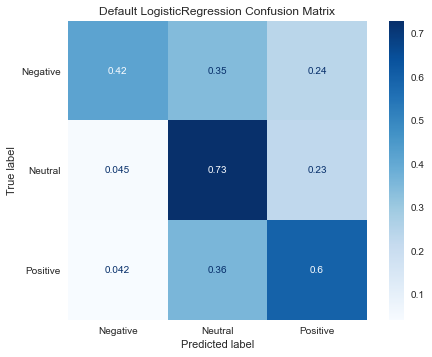

Running... MultinomialNB Model
Cross Validation Score: 0.7913
Test Accuracy Score: 0.6136



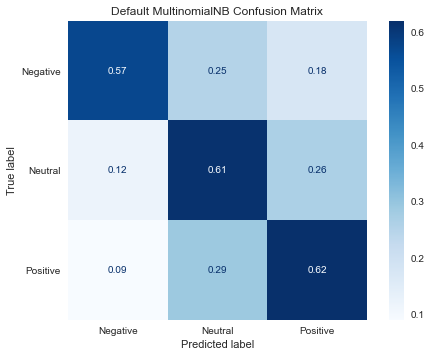

Running... DecisionTree Model
Cross Validation Score: 0.8203
Test Accuracy Score: 0.6171



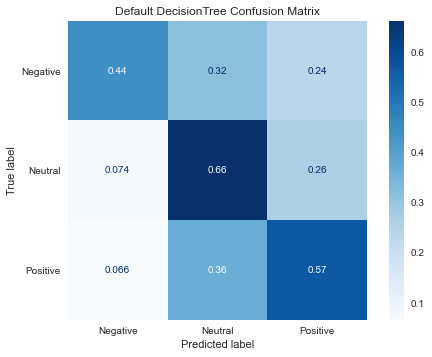

Running... RandomForest Model
Cross Validation Score: 0.852
Test Accuracy Score: 0.6746



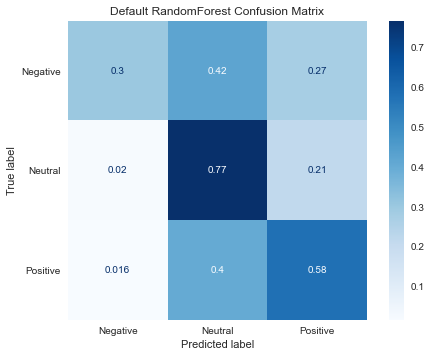

Running... ExtraTrees Model
Cross Validation Score: 0.8665
Test Accuracy Score: 0.6831



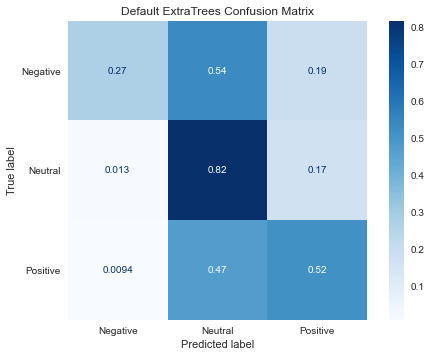

Running... GradientBoost Model
Cross Validation Score: 0.6388
Test Accuracy Score: 0.6073



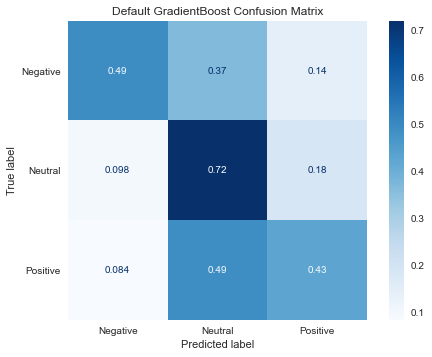

Running... VectorClass Model
Cross Validation Score: 0.862
Test Accuracy Score: 0.6818



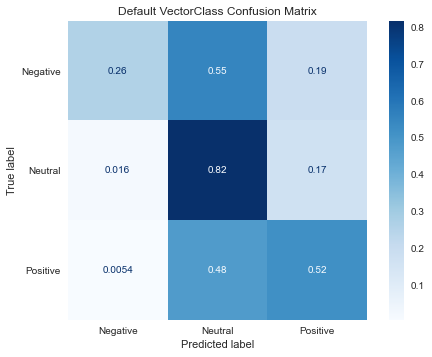

Running... SGDClassifier Model
Cross Validation Score: 0.8409
Test Accuracy Score: 0.6647



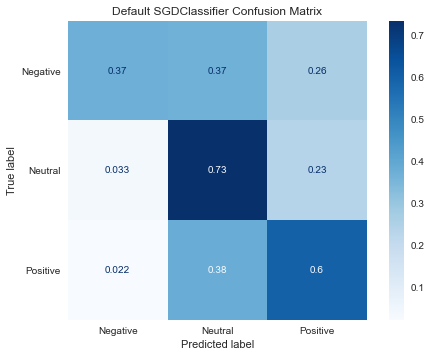

,Model,CV Score,Accuracy,Type
0,LogisticRegression,0.8313,0.6652,Default
1,MultinomialNB,0.7913,0.6136,Default
2,DecisionTree,0.8203,0.6171,Default
3,RandomForest,0.852,0.6746,Default
4,ExtraTrees,0.8665,0.6831,Default
5,GradientBoost,0.6388,0.6073,Default
6,VectorClass,0.862,0.6818,Default
7,SGDClassifier,0.8409,0.6647,Default


In [83]:
default_metrics = run_model(default_models, 'Default', 'Blues')
default_metrics

### 4.2 Hyperparameter Tuning

`GridSearchCV` ([notebook](https://github.com/czarinagluna/Twitter-Sentiment-Analysis/blob/main/GridSearchCV.ipynb)) is performed to optimize the classification models.


In [84]:
def optimize_model(models, classifier, classifier_name, params):
    '''
    Uses optimal parameters from grid search to tune model's hyperparameters.
    '''
    best_params = {}
    
    for param, values in params.items():
        parameter = param.replace('classifier__', '')
        best_params[parameter] = values
        
    models[classifier_name]['classifier'] = classifier(**best_params)

In [85]:
tuned_models = default_models.copy()

0. Logistic Regression:

In [86]:
%store -r lr_best_params

In [87]:
optimize_model(tuned_models, LogisticRegression, 'LogisticRegression', lr_best_params)

1. Multinomial Naive Bayes:

In [88]:
%store -r mn_best_params

In [89]:
optimize_model(tuned_models, MultinomialNB, 'MultinomialNB', mn_best_params)

2. Decision Tree:

In [90]:
%store -r dt_best_params

In [91]:
optimize_model(tuned_models, DecisionTreeClassifier, 'DecisionTree', dt_best_params)

3. Random Forest:

In [92]:
%store -r rf_best_params

In [93]:
optimize_model(tuned_models, RandomForestClassifier, 'RandomForest', rf_best_params)

4. Extra Trees:

In [94]:
%store -r et_best_params

In [95]:
optimize_model(tuned_models, ExtraTreesClassifier, 'ExtraTrees', et_best_params)

5. Gradient Boost:

In [96]:
%store -r gb_best_params

In [97]:
optimize_model(tuned_models, GradientBoostingClassifier, 'GradientBoost', gb_best_params)

6. Vector Class:

In [98]:
%store -r svc_best_params

In [99]:
optimize_model(tuned_models, SVC, 'VectorClass', svc_best_params)

7. Stochastic Gradient Descent:

In [100]:
%store -r sgd_best_params

In [101]:
optimize_model(tuned_models, SGDClassifier, 'SGDClassifier', sgd_best_params)

***

Running... LogisticRegression Model
Cross Validation Score: 0.8313
Test Accuracy Score: 0.6647



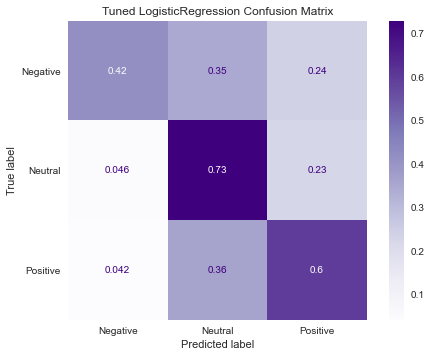

Running... MultinomialNB Model
Cross Validation Score: 0.8296
Test Accuracy Score: 0.6275



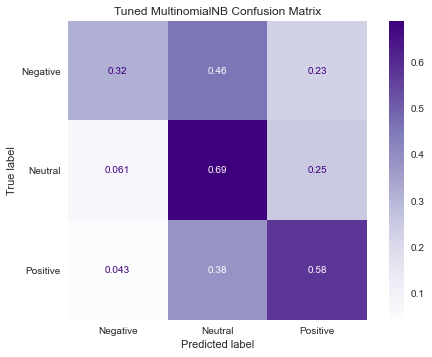

Running... DecisionTree Model
Cross Validation Score: 0.835
Test Accuracy Score: 0.6243



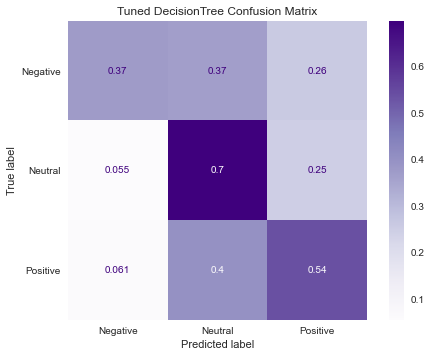

Running... RandomForest Model
Cross Validation Score: 0.8544
Test Accuracy Score: 0.671



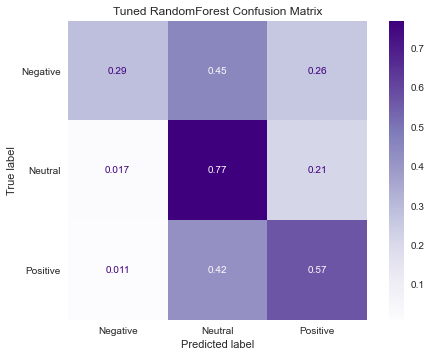

Running... ExtraTrees Model
Cross Validation Score: 0.8702
Test Accuracy Score: 0.6849



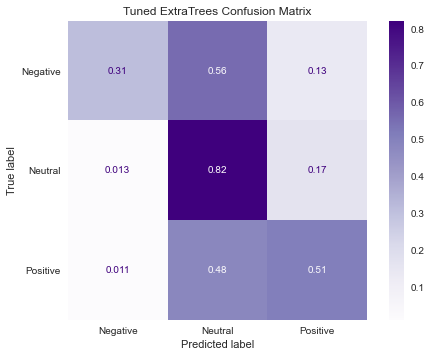

Running... GradientBoost Model
Cross Validation Score: 0.8475
Test Accuracy Score: 0.6566



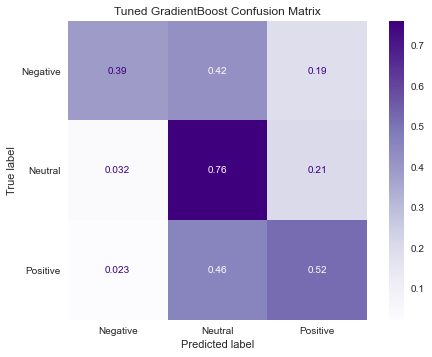

Running... VectorClass Model
Cross Validation Score: 0.8726
Test Accuracy Score: 0.649



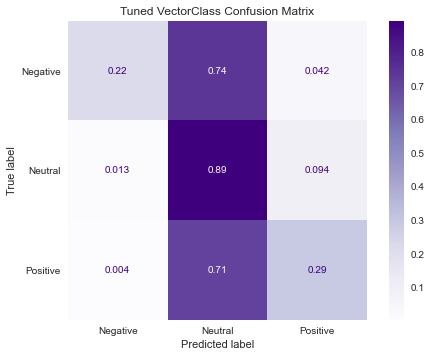

Running... SGDClassifier Model
Cross Validation Score: 0.8475
Test Accuracy Score: 0.6661



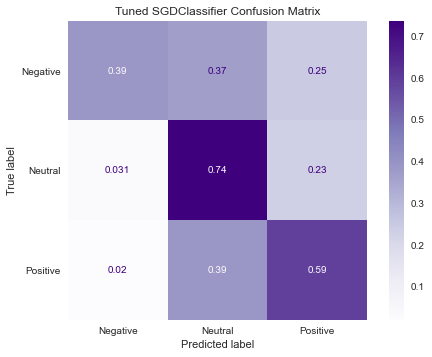

,Model,CV Score,Accuracy,Type
0,LogisticRegression,0.8313,0.6647,Tuned
1,MultinomialNB,0.8296,0.6275,Tuned
2,DecisionTree,0.835,0.6243,Tuned
3,RandomForest,0.8544,0.671,Tuned
4,ExtraTrees,0.8702,0.6849,Tuned
5,GradientBoost,0.8475,0.6566,Tuned
6,VectorClass,0.8726,0.649,Tuned
7,SGDClassifier,0.8475,0.6661,Tuned


In [102]:
tuned_metrics = run_model(tuned_models, 'Tuned', 'Purples')
tuned_metrics

### 4.3 Clustering Analysis

Clustering text documents using the K-Means clustering algorithm is completed on a separate notebook ([link](https://github.com/czarinagluna/sxsw-sentiment-analysis/blob/main/clustering.ipynb)). The words are vectorized using the `Word2Vec` model and to reduce dimensionality, Principal Component Analysis `PCA` is applied to the word vectors, which are then stored in a dataframe with the $x$ and $y$ values. Using [Orange](https://orangedatamining.com/), an open source data mining toolkit, I explore a range of different $k$ values which are visualized in notebook linked above.

In [103]:
%store -r cluster_data

Here, I set the number of clusters to 6:

![](data/images/k=6.png)
***
**Silhouette Scores**

In [104]:
cluster_data.groupby('Cluster').agg(['count', 'mean'])['Silhouette']

,count,mean
Cluster,,
C1,1,0.500000
C2,544,0.671562
C3,8,0.694157
C4,112,0.621268
C5,60,0.598980
C6,275,0.598727


In [105]:
cluster_data.sort_values('count', ascending=False)[:20]

,x_values,y_values,count,word,Cluster,Silhouette
71,4.232746,-0.236558,1528.0,store,C1,0.500000
122,3.200685,3.263005,683.0,launch,C3,0.688537
124,3.783673,4.306313,663.0,social,C3,0.702629
36,4.860034,-0.365946,598.0,android,C5,0.577045
127,3.717602,4.206253,587.0,circle,C3,0.709477
129,3.582466,3.000314,577.0,today,C3,0.684160
125,3.420786,4.252448,467.0,network,C3,0.710541
131,3.671145,-0.488340,448.0,line,C5,0.593595
55,4.751184,-0.324246,401.0,party,C5,0.613791
12,4.564972,-0.364521,388.0,free,C5,0.616656


Cluster `WordClouds`

![](data/images/clustering.png)

Clustering shows interesting results. For instance, Cluster 3 contains the exact words describing a major event "possibly today" that was supposedly the launch of Google's social networking platform called Circles but which did **not** actually happen at the conference, and yet talked about all over Twitter. Case in point:

<img src="data/images/tweet.png" width="500"/>

## V. Results and Recommendations

Model Performance:

In [106]:
all_models = pd.concat([default_metrics, tuned_metrics], ignore_index=True)
all_models

,Model,CV Score,Accuracy,Type
0,LogisticRegression,0.8313,0.6652,Default
1,MultinomialNB,0.7913,0.6136,Default
2,DecisionTree,0.8203,0.6171,Default
3,RandomForest,0.852,0.6746,Default
4,ExtraTrees,0.8665,0.6831,Default
5,GradientBoost,0.6388,0.6073,Default
6,VectorClass,0.862,0.6818,Default
7,SGDClassifier,0.8409,0.6647,Default
8,LogisticRegression,0.8313,0.6647,Tuned
9,MultinomialNB,0.8296,0.6275,Tuned


The Support Vector Machine for classification reaches the best cross validation score of 0.8726 followed closely by the Extra Trees with only 0.0024 difference, but the final evaluation on the test set shows that the Tuned Extra Trees classifier attains the highest score of 68.5% accuracy.

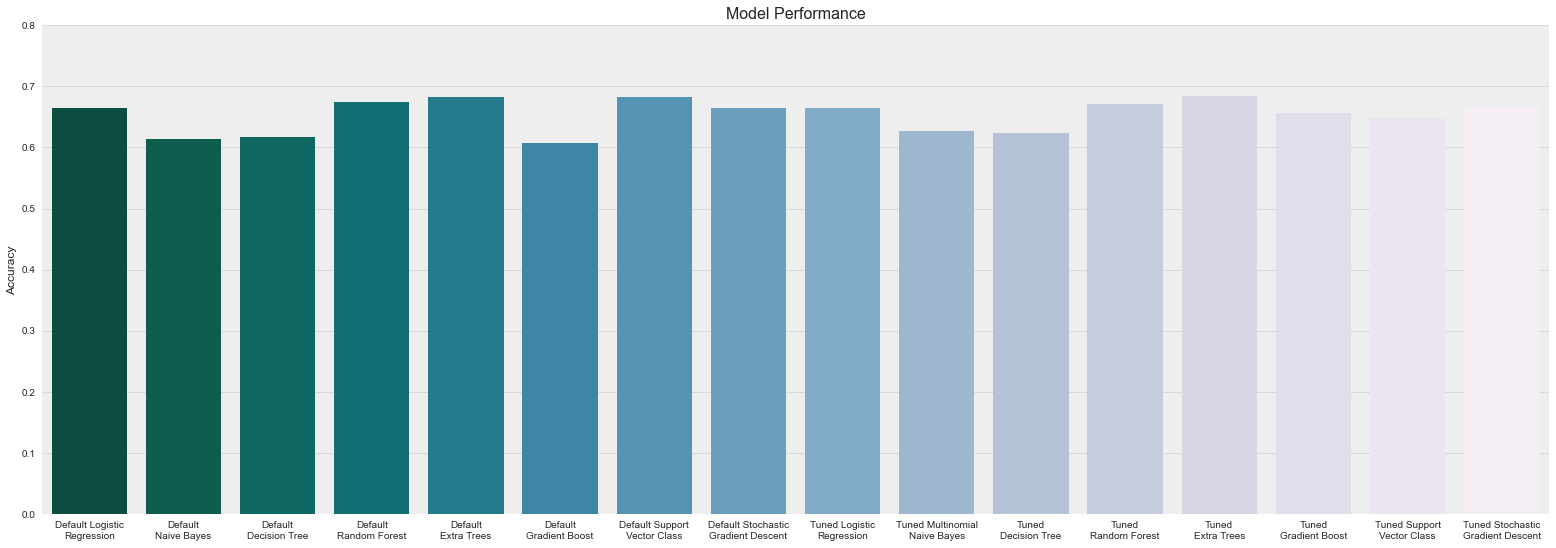

In [107]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(27,9))

sns.barplot(x=all_models.index, y='Accuracy', data=all_models, palette='PuBuGn_r', zorder=99)
ax.set_title('Model Performance', fontsize=16)
ax.set(xlabel=None)

labels = ['Default Logistic\nRegression', 'Default\nNaive Bayes', 'Default\nDecision Tree', 'Default\nRandom Forest', 
          'Default\nExtra Trees', 'Default\nGradient Boost', 'Default Support\nVector Class', 'Default Stochastic\nGradient Descent', 
          'Tuned Logistic\nRegression', 'Tuned Multinomial\nNaive Bayes', 'Tuned\nDecision Tree', 'Tuned\nRandom Forest', 
          'Tuned\nExtra Trees', 'Tuned\nGradient Boost', 'Tuned Support\nVector Class', 'Tuned Stochastic\nGradient Descent']

plt.xticks(all_models.index, labels)
plt.ylim(0,0.8)

plt.savefig('data/images/fig13.png', dpi=200, transparent=True)
plt.show()

Comparing the earlier confusion matrices of the models above, the final model that I choose for this problem is the **Multinomial Naive Bayes**. Though the Extra Trees classifier has a higher accuracy, it performs worse on the specific tasks of detecting negative and positive sentiments. 

- The misclassification of negative sentiments can be *more costly* to the conference organizers and companies featured at the events if more negative sentiments are spread online and missed. 
- The correct classification of positive sentiments can be more beneficial to understand and provide satisfaction to the attendees.

The **Final Model** increases the number of True Negatives to 0.57 and the number of True Positives to 0.62 which are highest among all the other models. 

In [110]:
final = Pipeline(steps=[('tfifd', tfidf), ('final_model', MultinomialNB())])
final.fit(X_train_res, y_train_res)

final_pred = final.predict(X_test_processed)
accuracy_score(y_test, final_pred)

0.6135547576301615

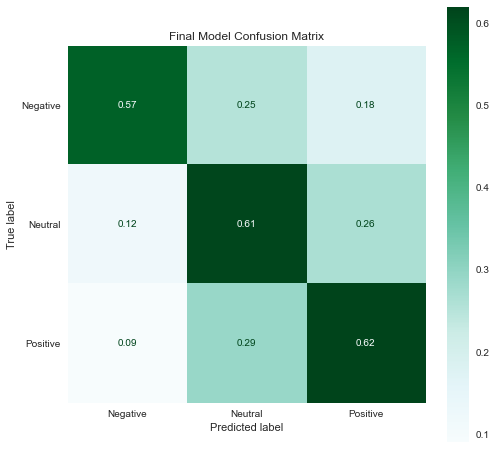

In [111]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8,8))

# Plot the confusion matrix of the final model
plot_confusion_matrix(final, X_test_processed, y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='BuGn')
plt.title('Final Model Confusion Matrix')
plt.grid(False)

plt.savefig('data/images/fig14.png', dpi=200, transparent=True)
plt.show()

***
**Recommendations** 

- Detect sentiments during the conference using the machine learning model to predict positive and negative sentiments. Positive sentiments can be shared and negative sentiments can be addressed by responding to the concerns.
- Present findings to the companies at the conference to receive feedback about their products and to provide better services the next year. Marketing for Google Circles can use the excitement and speculation during the conference for example.
- Speakers at the conference can drive positive and negative sentiments so take advantage of the remarks that people talk about and use them to increase user engagement.

## VI. Further Research

For further research, the data should be updated with more recent tweets, and more advanced models should be explored such as the recent Transformers.

# Contact

Feel free to contact me for any questions and connect with me on [Linkedin](https://www.linkedin.com/in/czarinagluna/).